In [1]:
import pandas as pd
import numpy as np
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.model_selection import grid_search_forecaster
import matplotlib.pyplot as plt

# Pronóstico Porductos Categoria 1

## Preprocesado de los datos

Se cargan los datos y se utilizan únicamente los que estan en la categoria 1. Adempas se verifica que no existan huecos en la serie temporal y se orden los datos por fecha para tener la serie temporal completa.

In [2]:
data = pd.read_csv('../dataset/series.csv')
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data[data["CATEGORY"]=="CATEG-1"]
data= data.drop(columns=["CATEGORY"])
data = data.set_index('DATE')
data = data.sort_index()
data = data[1:] # Remove outlier 2018 value
data = data.asfreq(freq ='D')
data.head(3)

,UNITS_SOLD
DATE,
2019-06-11,27
2019-06-12,26
2019-06-13,24


Se dividen en los datos en entrenamiento, test y validación y se validan en una grafica de la serie temporal

Fechas train : 2019-06-11 00:00:00 --- 2021-05-18 00:00:00  (n=708)
Fechas test  : 2021-05-19 00:00:00 --- 2021-08-14 00:00:00  (n=88)
Fechas val  : 2021-08-15 00:00:00 --- 2021-11-12 00:00:00  (n=90)


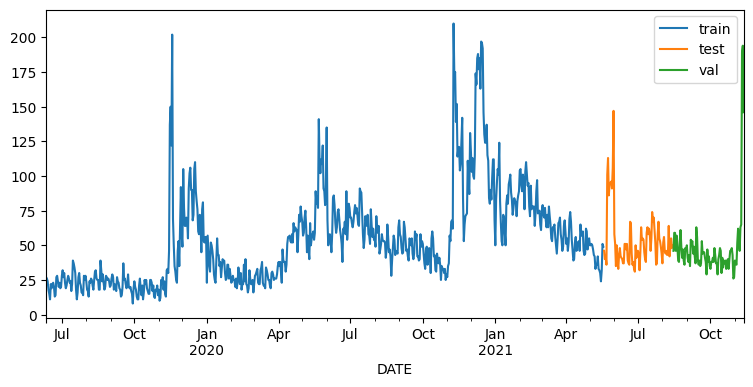

In [3]:
train_size = int(len(data)*0.8)
test_size = int(len(data)*0.1)
val_size = test_size

datos_train = data[:train_size]
datos_test  = data[train_size:train_size+test_size]
datos_val  = data[train_size+test_size:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")
print(f"Fechas val  : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
datos_test['UNITS_SOLD'].plot(ax=ax, label='test')
datos_val['UNITS_SOLD'].plot(ax=ax, label='val')
ax.legend();

## Modelo de Pronóstico

Se prueban dos modelos uno es el **RandomForestRegressor** y además se prueba le **XGBRegressor** además se usa el método GridSearchCV para encontar un conjunto de hiperpárametros de ambos modelos que den mejores resultados

In [4]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 60
             )

forecaster.fit(y=datos_train['UNITS_SOLD'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60] 
Transformer for y: None 
Transformer for exog: None 
Window size: 60 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-06-11 00:00:00'), Timestamp('2021-05-18 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start':

In [5]:
steps = len(datos_test)
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2021-05-19    48.00
2021-05-20    49.32
2021-05-21    48.38
2021-05-22    47.93
2021-05-23    54.29
Freq: D, Name: pred, dtype: float64

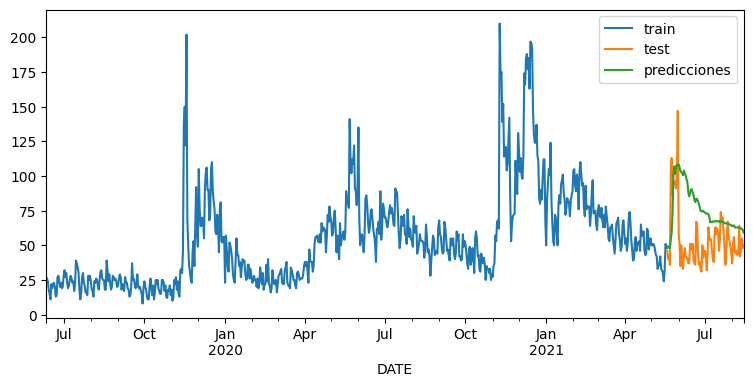

In [6]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
datos_test['UNITS_SOLD'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [7]:

error_mse = mean_squared_error(
                y_true = datos_test['UNITS_SOLD'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 1009.0114840909092


Intento con XGBoostGregressor

In [8]:
xgb = ForecasterAutoreg(
                regressor = XGBRegressor(learning_rate= 0.1, max_depth=3, subsample=0.5, random_state=42, n_jobs=-1),
                lags = 60
             )

xgb.fit(y=datos_train['UNITS_SOLD'])

In [9]:
steps = len(datos_test)
predicciones = xgb.predict(steps=steps)
predicciones.head(5)

2021-05-19    47.647404
2021-05-20    46.831402
2021-05-21    46.266285
2021-05-22    44.806042
2021-05-23    54.431767
Freq: D, Name: pred, dtype: float64

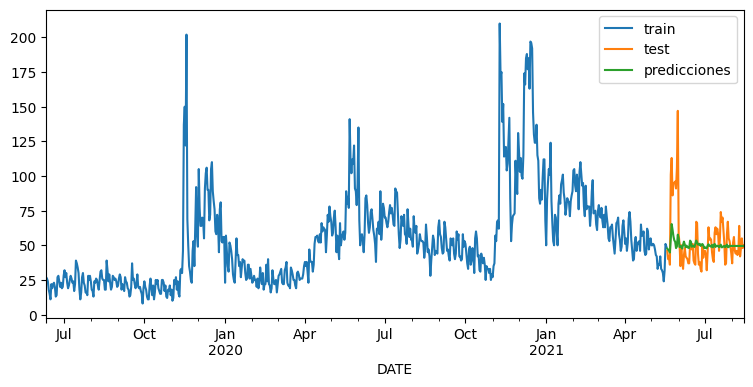

In [10]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
datos_test['UNITS_SOLD'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [11]:
error_mse = mean_squared_error(
                y_true = datos_test['UNITS_SOLD'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 349.6624668149609


## Fine Tunning

Se utiliza GridSearch para intentar buscar mejores párametros, pero al colocar esos parametros el modelo la verdad no mejora mucho, se podria intentar con un otros métodos como RandomSearchCV

In [13]:
steps = len(datos_test)
xgb = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=42, n_jobs=-1),
                lags      = 60
             )


param_grid = {
"n_estimators":  [5, 100, 200,],
"learning_rate": [0.01, 0.1, 0.3]
}
lags_grid = [60]

resultados_grid = grid_search_forecaster(
                        forecaster         = xgb,
                        y                  = datos_train['UNITS_SOLD'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.8),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 9.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:12<00:00, 12.44s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60] 
  Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
  Backtesting metric: 299.8278664069218



In [14]:
resultados_grid

,lags,params,mean_squared_error,learning_rate,n_estimators
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'n_estimators': 100}",299.827866,0.10,100.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'n_estimators': 200}",302.530999,0.10,200.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'n_estimators': 200}",1404.982938,0.30,200.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'n_estimators': 100}",1405.120674,0.30,100.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'n_estimators': 5}",2635.860634,0.30,5.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'n_estimators': 200}",2724.646955,0.01,200.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'n_estimators': 100}",3608.973211,0.01,100.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'n_estimators': 5}",4065.680439,0.10,5.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'n_estimators': 5}",4760.494200,0.01,5.0


In [16]:
steps = 132
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 60
             )

# Lags utilizados como predictores
lags_grid = [60]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [50, 100, 500, 700],
              'max_depth': [3, 5, 10, 20]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['UNITS_SOLD'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.99),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 16.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:39<00:00, 39.28s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60] 
  Parameters: {'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 87.37846543369149



In [17]:
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 50}",87.378465,3,50
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 100}",88.144412,20,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",90.915362,3,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",91.820347,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 700}",94.780158,10,700
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 700}",95.660433,20,700
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",96.266776,10,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",96.484868,3,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 700}",96.552249,3,700
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 500}",97.216714,20,500


In [18]:
regressor = RandomForestRegressor(n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 60
             )

forecaster.fit(y=datos_train['UNITS_SOLD'])

In [22]:
predicciones = forecaster.predict(steps=88)

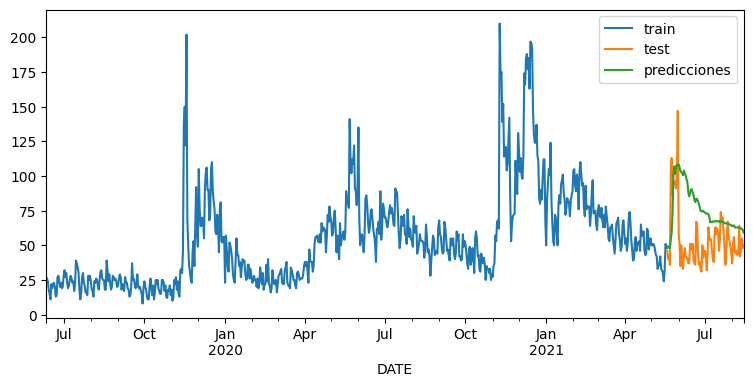

In [23]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
datos_test['UNITS_SOLD'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [24]:
error_mse = mean_squared_error(
                y_true = datos_test['UNITS_SOLD'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 1009.0114840909092


Se observan errores cuadraticos muy altos, alta oportunidad de mejora para los modelos

Pronostico de productos de la cateogira 1 para las siguientes 3 semanas (21 días)

In [25]:
steps = 21
predicciones = forecaster.predict(steps=steps)

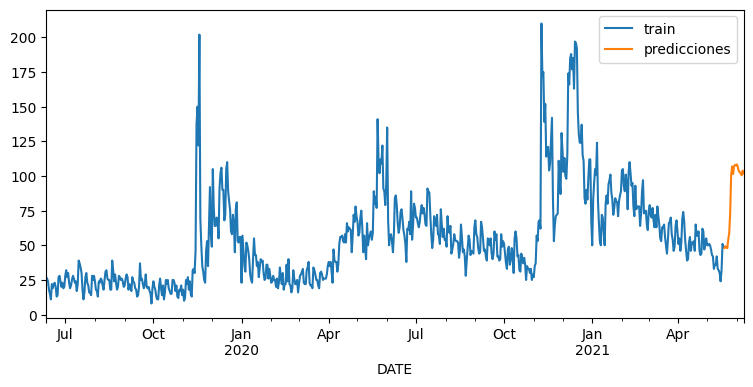

In [26]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

# Pronostico Productos Categoria 2

El proceso es similar al realizado con los productos de categoria 1, pero solo se utiliza un RandomForecastRegressor, pero siempre es buena practica intentar mas modelos y buscar la mejor selección de hiperpárametros. En este daset hay algunos valores faltantes para completar la serie temporal, estos se llenan usand el método **pad** en función de pandas asfreq() para tomar el valor anterior y asi tener la serie temporal completa.

In [27]:
data = pd.read_csv('../dataset/series.csv')
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data[data["CATEGORY"]=="CATEG-2"]
data= data.drop(columns=["CATEGORY"])
data = data.set_index('DATE')
data = data.sort_index()
data = data[1:]
data = data.asfreq(freq ='D', method='pad')
data.head(3)

,UNITS_SOLD
DATE,
2019-06-11,15
2019-06-12,13
2019-06-13,8


Fechas train : 2019-06-11 00:00:00 --- 2021-05-18 00:00:00  (n=708)
Fechas test  : 2021-05-19 00:00:00 --- 2021-08-14 00:00:00  (n=88)
Fechas val  : 2021-08-15 00:00:00 --- 2021-11-12 00:00:00  (n=90)


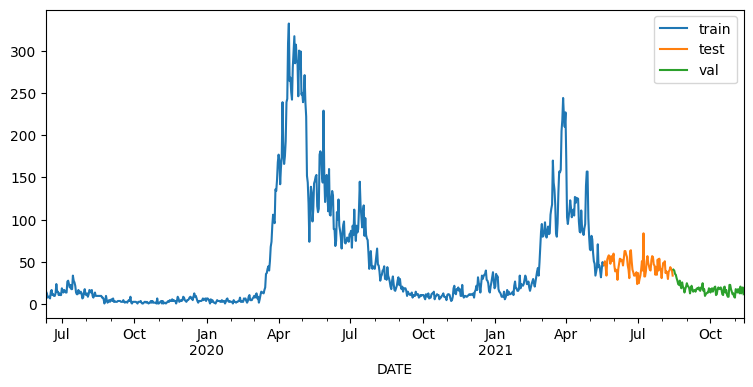

In [28]:
train_size = int(len(data)*0.8)
test_size = int(len(data)*0.1)
val_size = test_size

datos_train = data[:train_size]
datos_test  = data[train_size:train_size+test_size]
datos_val  = data[train_size+test_size:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")
print(f"Fechas val  : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
datos_test['UNITS_SOLD'].plot(ax=ax, label='test')
datos_val['UNITS_SOLD'].plot(ax=ax, label='val')
ax.legend();

In [29]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 60
             )

forecaster.fit(y=datos_train['UNITS_SOLD'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60] 
Transformer for y: None 
Transformer for exog: None 
Window size: 60 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-06-11 00:00:00'), Timestamp('2021-05-18 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start':

In [30]:
steps = len(datos_test)
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2021-05-19    45.56
2021-05-20    44.16
2021-05-21    43.34
2021-05-22    42.47
2021-05-23    44.14
Freq: D, Name: pred, dtype: float64

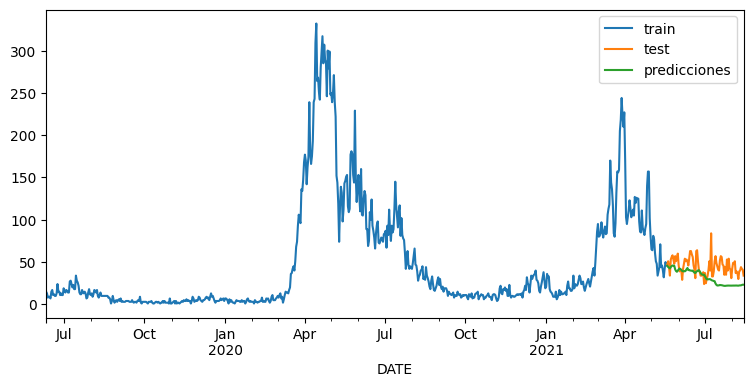

In [31]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
datos_test['UNITS_SOLD'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [32]:
error_mse = mean_squared_error(
                y_true = datos_test['UNITS_SOLD'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 303.96304886363635


Pronostica de venta de las siguientes 3 semanas (21 días) para productos de la categoria 2.

In [33]:
steps = 21
predicciones = forecaster.predict(steps=steps)

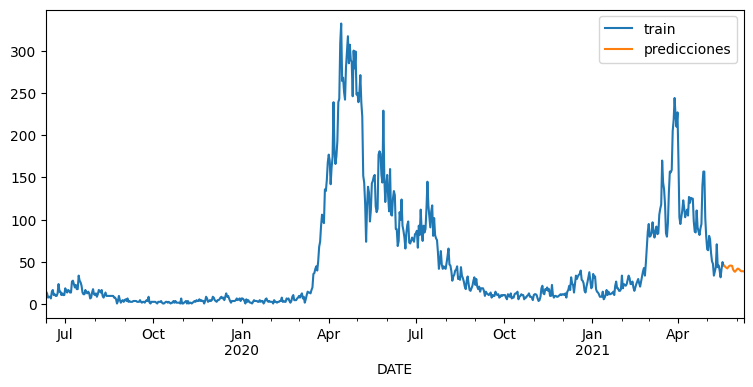

In [34]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

# Pronostico productos de la cateogira 3

Se realiza un proceso muy similar al anterior, en este caso también se utiliza solo un RandomForestRegressor

In [35]:
data = pd.read_csv('../dataset/series.csv')
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data[data["CATEGORY"]=="CATEG-3"]
data= data.drop(columns=["CATEGORY"])
data = data.set_index('DATE')
#Se eliman datos basura del inicio de la serie temporal y que arrancan con valores muy bajos
data = data[data["UNITS_SOLD"]>10]
data = data.sort_index()
data = data[1:]
data = data.asfreq(freq ='D')
data.head(3)

,UNITS_SOLD
DATE,
2019-06-12,679
2019-06-13,561
2019-06-14,520


Fechas train : 2019-06-12 00:00:00 --- 2021-05-19 00:00:00  (n=708)
Fechas test  : 2021-05-20 00:00:00 --- 2021-08-15 00:00:00  (n=88)
Fechas val  : 2021-08-16 00:00:00 --- 2021-11-12 00:00:00  (n=89)


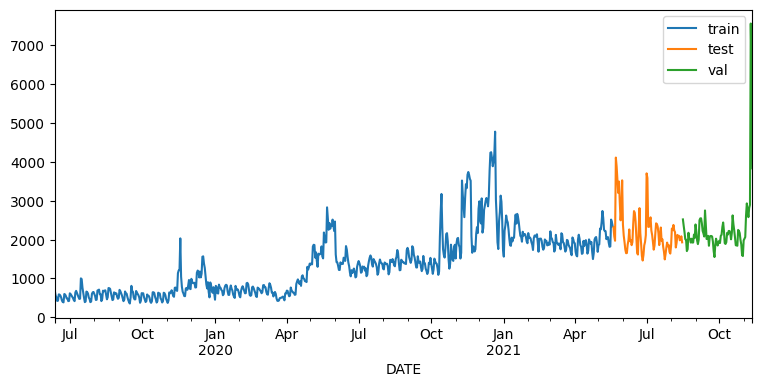

In [36]:
train_size = int(len(data)*0.8)
test_size = int(len(data)*0.1)
val_size = test_size

datos_train = data[:train_size]
datos_test  = data[train_size:train_size+test_size]
datos_val  = data[train_size+test_size:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")
print(f"Fechas val  : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
datos_test['UNITS_SOLD'].plot(ax=ax, label='test')
datos_val['UNITS_SOLD'].plot(ax=ax, label='val')
ax.legend();

In [37]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 60
             )

forecaster.fit(y=datos_train['UNITS_SOLD'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60] 
Transformer for y: None 
Transformer for exog: None 
Window size: 60 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-06-12 00:00:00'), Timestamp('2021-05-19 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start':

In [38]:
steps = len(datos_test)
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2021-05-20    2371.98
2021-05-21    2324.81
2021-05-22    2224.57
2021-05-23    2213.13
2021-05-24    2225.55
Freq: D, Name: pred, dtype: float64

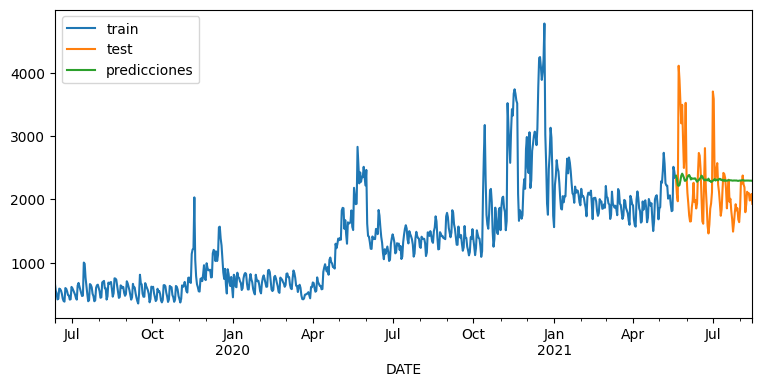

In [39]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
datos_test['UNITS_SOLD'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [40]:
error_mse = mean_squared_error(
                y_true = datos_test['UNITS_SOLD'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 315159.7500693182


Este modelo tiene un error mucho más alto comparado al hecho para las demas categorias, se podria mirar otro tipo de modelo diferentes solo para esta categoria en especificio.

In [41]:
steps = 21
predicciones = forecaster.predict(steps=steps)

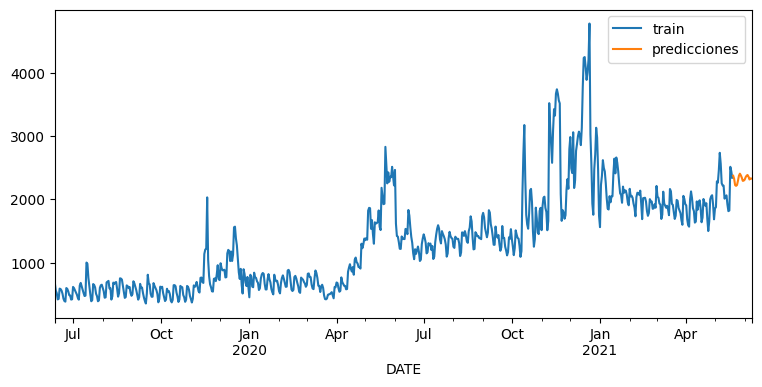

In [42]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['UNITS_SOLD'].plot(ax=ax, label='train')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();